In this notebook, we will use elastic net to predict the kinetic constant $k_{cat}$ from 59 features generated from Rosetta models 

In [44]:
import pandas 
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.cross_validation import cross_val_predict

from scipy.stats import pearsonr

%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use( 'ggplot' )

In [45]:
params = [ 'kcat', 'km', 'kcatkm', 'tm' ] 

First, we will select the lowest 10% of `total_energy` Rosetta models, and then average the features 

In [46]:
f_set = pandas.read_csv( '../rosetta_runs/benchmark/benchmark_feature_set.csv' )
f_set = f_set.groupby( 'description' ).apply( lambda x: x.sort_values( by='total_score' ).head( 10 ).mean() )
#scl = StandardScaler()
scl = MinMaxScaler()
f_set = pandas.DataFrame( scl.fit_transform( f_set ), columns=f_set.columns, index=f_set.index )

Next, we normalize the data set to the wild type value of 800 min$^{-1}$

In [47]:
df = pandas.read_csv( '/Users/alex/Documents/bagel-thermal/data_sets/experimental_data/data_set.csv', index_col=0, na_values='?' )
df.kcat = np.log10( df.kcat / 888 )
df.km = np.log10( df.km / 5 )
df.kcatkm = np.log10( df.kcatkm / 174000 )
df.tm = df.tm - 39.93 

Make sure we're not missing features!

In [48]:
df.index.difference( f_set.index ) 

Index(['BglB', 'E164G', 'E353A', 'E423S'], dtype='object')

Join the features to the experimental data 

In [49]:
df = df.join( f_set )

In [50]:
my_features = []

for param in params:
    my_df = df[ [ param ] + list( f_set.columns ) ].dropna()
    X = my_df.ix[ : , 1: ]
    y = my_df.ix[ : , 0 ]

    print( param, X.shape, y.shape )
    my_features.append( ( param, X, y ) ) 

kcat (77, 59) (77,)
km (77, 59) (77,)
kcatkm (88, 59) (88,)
tm (70, 59) (70,)


Last, we will use nested cross validation to find the best model for each of the params

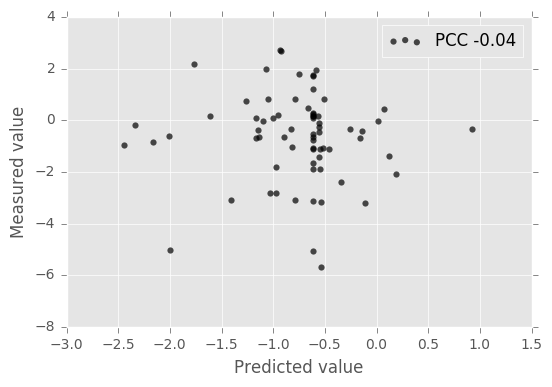

In [53]:
clf = ElasticNetCV( cv=2, max_iter=1e4, eps=1e-1 )
preds = cross_val_predict( clf, X, y, cv=4 ) 
plt.scatter( preds, y, c='k', lw=0, alpha=0.7 )
plt.ylabel( 'Measured value' )
plt.xlabel( 'Predicted value' ) 
plt.legend( [ 'PCC {}'.format( pearsonr( preds, y )[0].round( 2 ) ) ] )